**Модуль 10. Згорткові нейронні мережі**

---
**Частина 2**

Створити згорткову нейромережу, що використовує VGG16 в якості згорткової основи.


Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Під час навчання використовуйте прийоми донавчання та виділення ознак.


Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist

import matplotlib.pyplot as plt

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras import optimizers
from keras import losses
from keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
import copy
import numpy as np
from PIL import Image

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
def resize_images(images):
    resized_images = []
    for img in images:
        # Resize the image to 32x32 using bilinear interpolation
        img_resized = np.array(Image.fromarray(img).resize((32, 32), Image.BILINEAR))
        # Convert grayscale to RGB format by replicating the single channel
        img_rgb = np.repeat(img_resized[:, :, np.newaxis], 3, axis=2)
        resized_images.append(img_rgb)
    return np.array(resized_images)

In [ ]:
train_images = resize_images(train_images)
test_images = resize_images(test_images)

**Перевірка датасету**

In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)


(60000, 32, 32, 3)
(60000,)
(10000, 32, 32, 3)
(10000,)


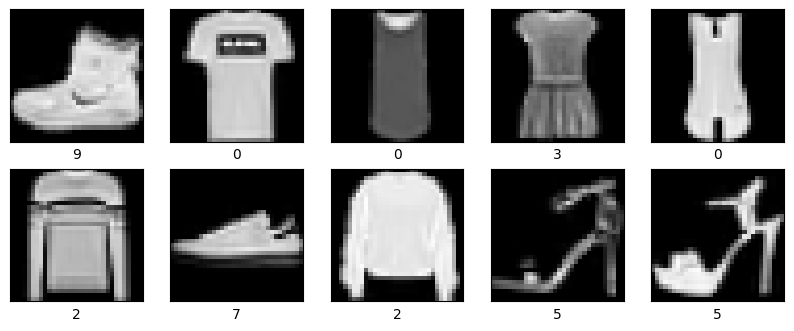

In [ ]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

**Функція відображення графіків втрат і точності на наборах даних**

In [ ]:
def plot_history(history):
    train_loss = history.history['loss']
    train_acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, 'r', label='Втрати на тренувальному наборі')
    plt.plot(epochs, val_loss, 'b', label='Втрати на тестовому наборі')
    plt.plot(epochs, train_acc, 'g', label='Точність на тренувальному наборі')
    plt.plot(epochs, val_acc, 'y', label='Точність на тестовому наборі')

    plt.title('Втрати та точність на тренувальному та тестовому наборі')
    plt.xlabel('Епоха')
    plt.ylabel('Метрики')
    plt.legend()
    plt.show()

**Функція пошуку оптимальних параметрів**

In [ ]:
def find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model_func):
    best_accuracy = 0.0
    best_parameters = {}

    base_model_vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    for param in study_sequence:
        print(f"Searching for optimal value for parameter: {param}")
        param_values = parameters[param]
        best_value = optimal_parameters[param]
        for value in param_values:
            optimal_parameters[param] = value
            print(f"Testing value: {value}")
            model, history, (test_loss, test_acc), (train_loss, train_acc) = train_model_func(train_images, train_labels, test_images, test_labels, base_model=base_model_vgg16, **optimal_parameters)
            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_parameters = copy.deepcopy(optimal_parameters)
                best_value = value
            # Результати навчання для параметра
            print(f"Досліджений параметр {param} = {value}")

            plot_history(history)
            print('Parameters', optimal_parameters)
            print('test_loss =', test_loss)
            print('test_acc =', test_acc)
            print('train_loss =', train_loss)
            print('train_acc =', train_acc)

        # Update optimal parameter for the current parameter
        optimal_parameters[param] = best_value
        print(f"Optimal value for parameter {param}: {best_value}, test accuracy: {best_accuracy}")
        print()

    print("Optimal parameters:")
    print(best_parameters)
    print(f"Test accuracy: {best_accuracy}")
    return best_parameters, best_accuracy


**Модель для тренування 1**

---


In [ ]:
base_model_vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
def train_model(train_images, train_labels, test_images, test_labels, base_model=base_model_vgg16, epochs=20, batch_size=32, dropout_rate=0.1,
                loss_function='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']):
    #base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics)

    history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels))

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Точність на тестових даних:', test_acc)

    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print('Точність на тренувальних даних:', train_acc)

    return model, history, (test_loss, test_acc), (train_loss, train_acc)



**Перевірка моделі 1 на параметрах за замовчанням**

In [ ]:
model_1_testing = train_model(train_images, train_labels, test_images, test_labels,
                              base_model=base_model_vgg16,
                              epochs=20,
                              batch_size=32,
                              dropout_rate=0.1,
                              loss_function='sparse_categorical_crossentropy',
                              optimizer='adam',
                              metrics=['accuracy'])

Epoch 1/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.5980 - accuracy: 0.7898 - val_loss: 0.4798 - val_accuracy: 0.8264
Epoch 2/20
1875/1875 [==============================] - 18s 9ms/step - loss: 0.4388 - accuracy: 0.8418 - val_loss: 0.4272 - val_accuracy: 0.8453
Epoch 3/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.4043 - accuracy: 0.8513 - val_loss: 0.4018 - val_accuracy: 0.8518
Epoch 4/20
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3809 - accuracy: 0.8596 - val_loss: 0.3943 - val_accuracy: 0.8556
Epoch 5/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.3669 - accuracy: 0.8658 - val_loss: 0.3820 - val_accuracy: 0.8605
Epoch 6/20
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3555 - accuracy: 0.8692 - val_loss: 0.3809 - val_accuracy: 0.8638
Epoch 7/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.3457 - accuracy: 0.8712 - val_loss: 0.3849 - va

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 14748170 (56.26 MB)
Trainable params: 33482 (130.79 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


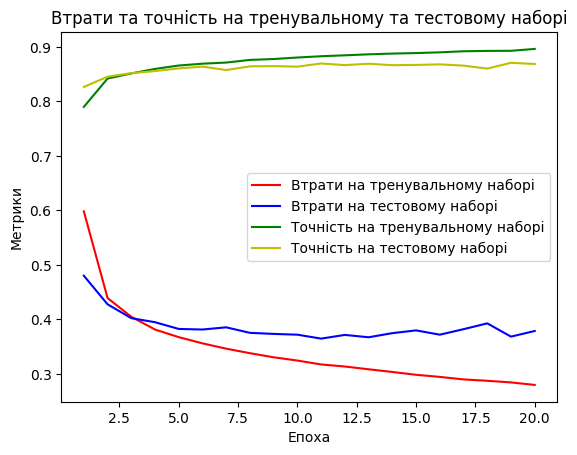

In [ ]:
model_1_testing[0].summary()
plot_history(model_1_testing[1])

In [ ]:
study_sequence = [
                  'optimizer',
 #                 'activation',
 #                 'hidden_units',
                  'dropout_rate',
                  'batch_size',
                  'loss_function']
#                  'metrics',
#                  'epochs']

optimal_parameters = {
    'epochs': 10,
    'batch_size': 32,
    'dropout_rate': 0.1,
    'loss_function': 'sparse_categorical_crossentropy',
    'optimizer': 'adam',
#    'activation': 'relu',
    'metrics': ['accuracy']
    }

# Списки параметрів, що мають бути досліджені під час навчання

parameters = {
    'epochs': [10, 20, 30],
    'batch_size': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'loss_function': ['sparse_categorical_crossentropy'],
    'optimizer': ['adam', 'rmsprop'],
#    'hidden_units': [128, 256, 512],
#    'activation': ['relu', 'tanh'],
    'metrics': ['accuracy']
    }


Searching for optimal value for parameter: optimizer
Testing value: adam
Epoch 1/10
1875/1875 [==============================] - 19s 9ms/step - loss: 0.5940 - accuracy: 0.7911 - val_loss: 0.4527 - val_accuracy: 0.8362
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4370 - accuracy: 0.8402 - val_loss: 0.4145 - val_accuracy: 0.8467
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4021 - accuracy: 0.8520 - val_loss: 0.4027 - val_accuracy: 0.8515
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3796 - accuracy: 0.8618 - val_loss: 0.3852 - val_accuracy: 0.8593
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3638 - accuracy: 0.8659 - val_loss: 0.3770 - val_accuracy: 0.8614
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3532 - accuracy: 0.8686 - val_loss: 0.3972 - val_accuracy: 0.8571
Epoch 7/10
1875/1875 [==============================] - 1

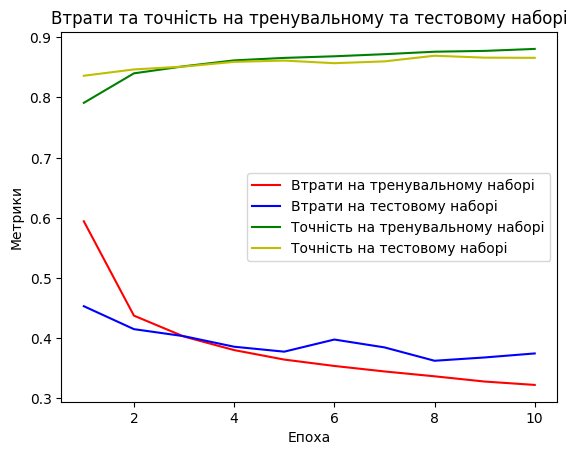

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.37405484914779663
test_acc = 0.8659999966621399
train_loss = 0.2930842638015747
train_acc = 0.8911666870117188
Testing value: rmsprop
Epoch 1/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.5977 - accuracy: 0.7900 - val_loss: 0.4543 - val_accuracy: 0.8357
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4435 - accuracy: 0.8396 - val_loss: 0.4358 - val_accuracy: 0.8411
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4138 - accuracy: 0.8494 - val_loss: 0.4069 - val_accuracy: 0.8521
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3993 - accuracy: 0.8562 - val_loss: 0.4145 - val_accuracy: 0.8506
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3880 - accuracy: 0.8614 - val

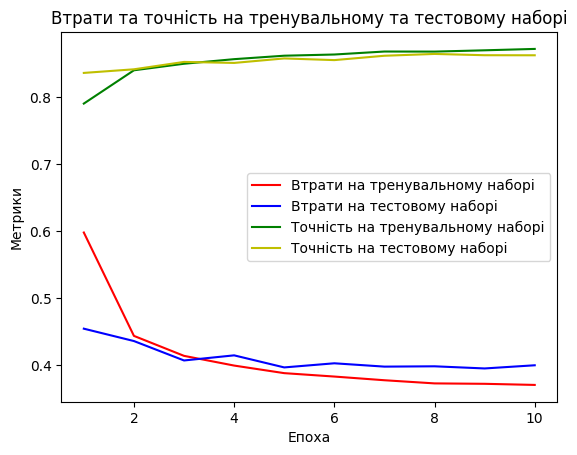

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'rmsprop', 'metrics': ['accuracy']}
test_loss = 0.3997044861316681
test_acc = 0.8619999885559082
train_loss = 0.3301754295825958
train_acc = 0.8840166926383972
Optimal value for parameter optimizer: adam, test accuracy: 0.8659999966621399

Searching for optimal value for parameter: dropout_rate
Testing value: 0.2
Epoch 1/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.6424 - accuracy: 0.7759 - val_loss: 0.4696 - val_accuracy: 0.8310
Epoch 2/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.4612 - accuracy: 0.8337 - val_loss: 0.4266 - val_accuracy: 0.8414
Epoch 3/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.4230 - accuracy: 0.8458 - val_loss: 0.4009 - val_accuracy: 0.8532
Epoch 4/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.4002 - accuracy: 0.8530 - val_loss: 0.

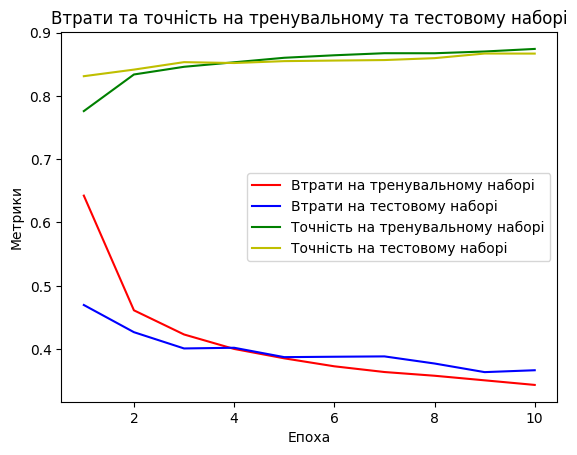

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.36649081110954285
test_acc = 0.8666999936103821
train_loss = 0.2988753318786621
train_acc = 0.888450026512146
Testing value: 0.3
Epoch 1/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.6629 - accuracy: 0.7696 - val_loss: 0.4689 - val_accuracy: 0.8308
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4817 - accuracy: 0.8277 - val_loss: 0.4230 - val_accuracy: 0.8449
Epoch 3/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.4444 - accuracy: 0.8398 - val_loss: 0.4139 - val_accuracy: 0.8475
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4220 - accuracy: 0.8472 - val_loss: 0.4134 - val_accuracy: 0.8449
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4078 - accuracy: 0.8530 - val_los

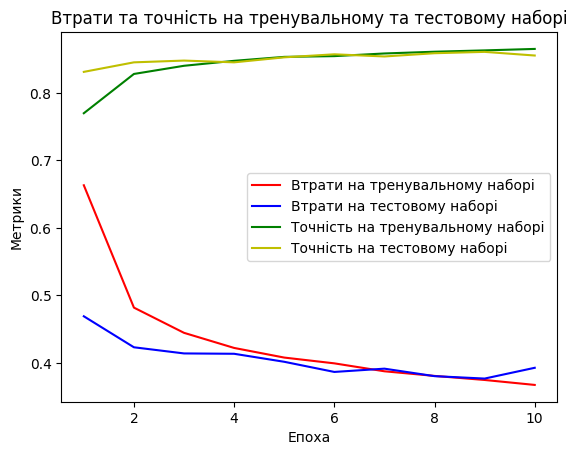

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.3, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.392649382352829
test_acc = 0.8550000190734863
train_loss = 0.3318711519241333
train_acc = 0.8771499991416931
Testing value: 0.4
Epoch 1/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.6998 - accuracy: 0.7559 - val_loss: 0.4776 - val_accuracy: 0.8257
Epoch 2/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.5088 - accuracy: 0.8188 - val_loss: 0.4303 - val_accuracy: 0.8444
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4682 - accuracy: 0.8309 - val_loss: 0.4209 - val_accuracy: 0.8436
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4501 - accuracy: 0.8377 - val_loss: 0.4067 - val_accuracy: 0.8487
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4323 - accuracy: 0.8429 - val_loss

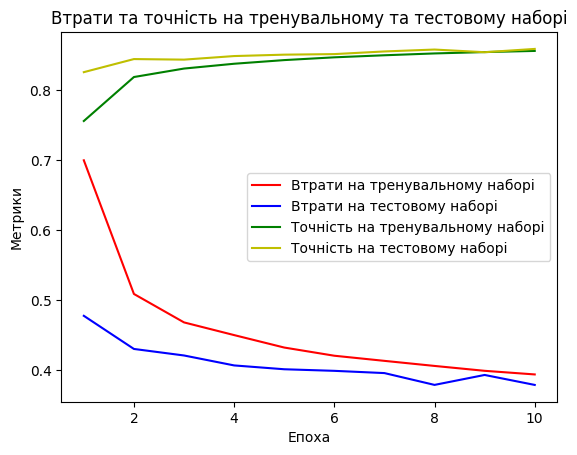

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.4, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.37886062264442444
test_acc = 0.8589000105857849
train_loss = 0.3231068253517151
train_acc = 0.8796833157539368
Optimal value for parameter dropout_rate: 0.2, test accuracy: 0.8666999936103821

Searching for optimal value for parameter: batch_size
Testing value: 32
Epoch 1/10
1875/1875 [==============================] - 20s 10ms/step - loss: 0.6361 - accuracy: 0.7775 - val_loss: 0.4595 - val_accuracy: 0.8301
Epoch 2/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.4610 - accuracy: 0.8341 - val_loss: 0.4252 - val_accuracy: 0.8429
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4270 - accuracy: 0.8457 - val_loss: 0.4029 - val_accuracy: 0.8524
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4043 - accuracy: 0.8537 - val_loss: 0.4009 

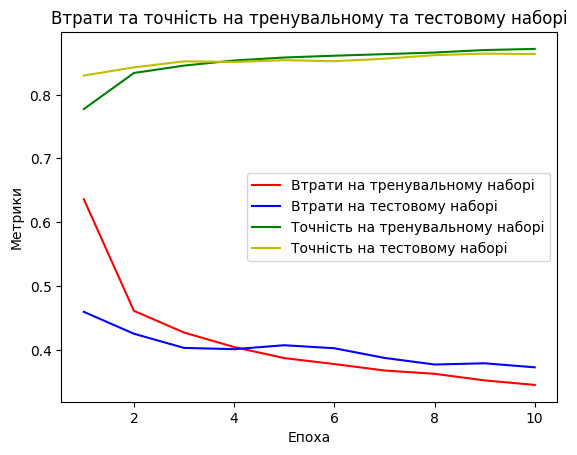

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.3724757730960846
test_acc = 0.8637999892234802
train_loss = 0.3028455674648285
train_acc = 0.8864333629608154
Testing value: 64
Epoch 1/10
938/938 [==============================] - 14s 13ms/step - loss: 0.6863 - accuracy: 0.7624 - val_loss: 0.4878 - val_accuracy: 0.8266
Epoch 2/10
938/938 [==============================] - 12s 13ms/step - loss: 0.4753 - accuracy: 0.8287 - val_loss: 0.4329 - val_accuracy: 0.8428
Epoch 3/10
938/938 [==============================] - 13s 14ms/step - loss: 0.4342 - accuracy: 0.8423 - val_loss: 0.4154 - val_accuracy: 0.8476
Epoch 4/10
938/938 [==============================] - 12s 13ms/step - loss: 0.4105 - accuracy: 0.8497 - val_loss: 0.4057 - val_accuracy: 0.8510
Epoch 5/10
938/938 [==============================] - 12s 13ms/step - loss: 0.3939 - accuracy: 0.8560 - val_loss: 0.388

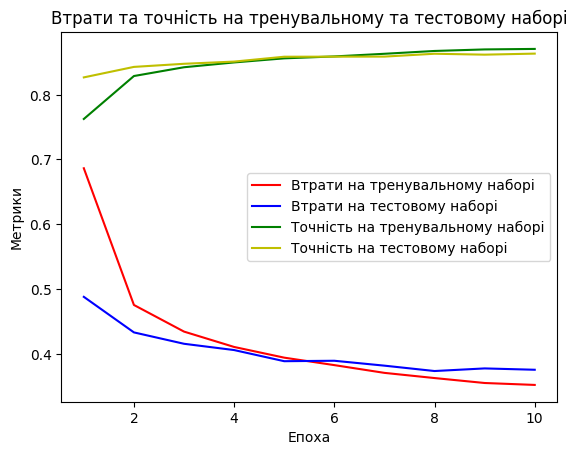

Parameters {'epochs': 10, 'batch_size': 64, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.37526029348373413
test_acc = 0.8633000254631042
train_loss = 0.310507595539093
train_acc = 0.883899986743927
Testing value: 128
Epoch 1/10
469/469 [==============================] - 13s 22ms/step - loss: 0.7625 - accuracy: 0.7394 - val_loss: 0.5130 - val_accuracy: 0.8156
Epoch 2/10
469/469 [==============================] - 9s 19ms/step - loss: 0.5061 - accuracy: 0.8206 - val_loss: 0.4562 - val_accuracy: 0.8337
Epoch 3/10
469/469 [==============================] - 9s 19ms/step - loss: 0.4543 - accuracy: 0.8369 - val_loss: 0.4282 - val_accuracy: 0.8454
Epoch 4/10
469/469 [==============================] - 9s 19ms/step - loss: 0.4269 - accuracy: 0.8454 - val_loss: 0.4184 - val_accuracy: 0.8483
Epoch 5/10
469/469 [==============================] - 9s 19ms/step - loss: 0.4063 - accuracy: 0.8518 - val_loss: 0.4024 - 

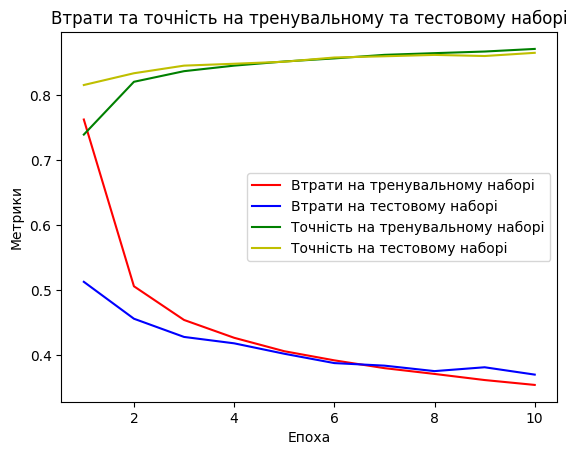

Parameters {'epochs': 10, 'batch_size': 128, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.37026193737983704
test_acc = 0.8651000261306763
train_loss = 0.31511417031288147
train_acc = 0.8830333352088928
Optimal value for parameter batch_size: 32, test accuracy: 0.8666999936103821

Searching for optimal value for parameter: loss_function
Testing value: sparse_categorical_crossentropy
Epoch 1/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.6322 - accuracy: 0.7784 - val_loss: 0.4615 - val_accuracy: 0.8335
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4601 - accuracy: 0.8328 - val_loss: 0.4292 - val_accuracy: 0.8463
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4258 - accuracy: 0.8461 - val_loss: 0.4103 - val_accuracy: 0.8502
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.4007 - accur

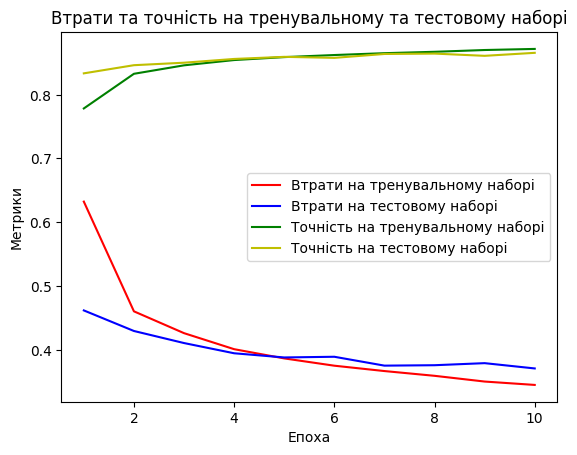

Parameters {'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
test_loss = 0.3704562783241272
test_acc = 0.8657000064849854
train_loss = 0.29696398973464966
train_acc = 0.8881166577339172
Optimal value for parameter loss_function: sparse_categorical_crossentropy, test accuracy: 0.8666999936103821

Optimal parameters:
{'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
Test accuracy: 0.8666999936103821


In [ ]:
find_optimal_1 = find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model)


Встановлені Оптимальні параметри для моделі 1 (без розморожування шарів):
Optimal parameters:
{'epochs': 10, 'batch_size': 32, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'metrics': ['accuracy']}
Test accuracy: 0.8666999936103821

Точність не достатньо висока. Можливо, через низьку роздільну здатність датасету.

**Ініціалізація і перевірка моделі 2**

---



In [ ]:
def train_model_2(train_images, train_labels, test_images, test_labels, base_model=base_model_vgg16, epochs=20, batch_size=32, dropout_rate=0.1,
                loss_function='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']):

    base_model.trainable = True
    set_trainable = False

    for layer in base_model_vgg16.layers:
        if layer.name == "block5_conv1":
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics)

    history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels), callbacks=[early_stopping])

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Точність на тестових даних:', test_acc)

    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print('Точність на тренувальних даних:', train_acc)

    return model, history, (test_loss, test_acc), (train_loss, train_acc)


In [ ]:
model_2_testing = train_model_2(train_images, train_labels, test_images, test_labels,
                              base_model=base_model_vgg16,
                              epochs=20,
                              batch_size=32,
                              dropout_rate=0.1,
                              loss_function='sparse_categorical_crossentropy',
                              optimizer='adam',
                              metrics=['accuracy'])

Epoch 1/20
1875/1875 [==============================] - 34s 17ms/step - loss: 0.4716 - accuracy: 0.8377 - val_loss: 0.3541 - val_accuracy: 0.8756
Epoch 2/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.3256 - accuracy: 0.8868 - val_loss: 0.3562 - val_accuracy: 0.8867
Epoch 3/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2957 - accuracy: 0.8953 - val_loss: 0.3330 - val_accuracy: 0.8885
Epoch 4/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2785 - accuracy: 0.9022 - val_loss: 0.3177 - val_accuracy: 0.8887
Epoch 5/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2572 - accuracy: 0.9092 - val_loss: 0.2932 - val_accuracy: 0.8937
Epoch 6/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2468 - accuracy: 0.9120 - val_loss: 0.3355 - val_accuracy: 0.8907
Epoch 7/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2410 - accuracy: 0.9134 - val_loss: 0.3164 -

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 14748170 (56.26 MB)
Trainable params: 33482 (130.79 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


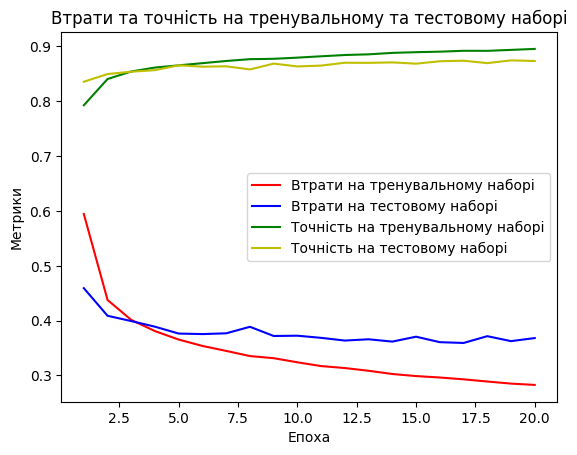

In [ ]:
model_2_testing[0].summary()
plot_history(model_2_testing[1])

In [ ]:
find_optimal_2 = find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model_2)


In [ ]:
def train_model_3(train_images, train_labels, test_images, test_labels, base_model=base_model_vgg16, epochs=20, batch_size=32, dropout_rate=0.1,
                loss_function='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']):
    #base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    base_model.trainable = True
    set_trainable = False

    for layer in base_model_vgg16.layers:
        if layer.name == "block5_conv1":
            set_trainable = True
        if layer.name == "block5_conv2":
            set_trainable = True
        if layer.name == "block5_conv3":
            set_trainable = True
        if set_trainable:
            layer.trainable = True

        else:
            layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics)

    history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels), callbacks=[early_stopping])

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Точність на тестових даних:', test_acc)

    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print('Точність на тренувальних даних:', train_acc)

    return model, history, (test_loss, test_acc), (train_loss, train_acc)




In [ ]:
find_optimal_3 = find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model_3)


In [ ]:
model_3_testing = train_model_3(train_images, train_labels, test_images, test_labels,
                              base_model=base_model_vgg16,
                              epochs=20,
                              batch_size=32,
                              dropout_rate=0.1,
                              loss_function='sparse_categorical_crossentropy',
                              optimizer='adam',
                              metrics=['accuracy'])

In [ ]:
model_3_testing[0].summary()
plot_history(model_3_testing[1])


Висновок

Під час використання техніки перенесення навчання з використанням натренованої моделі VGG16, виявлено, що результати стають задовільними при розмороженні та пренавчанні деяких внутрішніх шарів. Однак зміни у верхніх рівнях мережі не призвели до суттєвого поліпшення результатів. З іншого боку, використання моделі VGG16 без розмороження рівнів привело до більш стабільних результатів, що демонструється на графіках точності та втрат для тренувальних та тестових даних.
